# Machine Learning Model for Telco Customer Churn

## Background and Problem
Customer churn becomes one of the most important metrics to understand in a business. It tells us about how retain our customers towards our product/services. The higher the churn rate is, the more likely our customer to not use our product/service anymore, and this is concerning, since impacting to our revenue in a business. 

Therefore, in this dataset, we're going to learn what's the factor of customer churn from Telco Customer Churn dataset. 

The dataset is represented as follows

- Each row represents a customer, each column contains customer’s attributes described on the column Metadata.
- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents

Here, we're going to utilize machine learning classification model to predict whether the customer churn or not using Decision Tree, Random Forest, and XGBoost, and perform analytical metrics towards those model to see which one is better.

## Outlines

What we're going to cover in this notebook

1. Data Profiling and Cleaning
2. Data Transformation
3. Data Preparation
4. Baseline Model
5. Imbalanced Handling SMOTE
6. Decision Tree Visualizations : Educational Purposes
7. Hyperparameters Tuning
8. Conclusion

## Data Profiling and Cleaning

In this stage, we are going to get familiarity with the dataset in general by exploring certain things

- General info of the size and missing/null values of the dataset
- Description of the data
- Missing value handling
- Univariate analysis
- Bivariate analysis
- Multivariate analysis

In [1]:
# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import time
import re

pd.set_option('display.max_columns', 200)

plt.style.use('bmh')

%matplotlib inline

In [2]:
# Import Telco Customer Churn dataset
df = pd.read_csv('./dataset/churn.csv')

In [3]:
df.head()

,customerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0.0,NaN,No,1.0,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0.0,No,No,34.0,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0.0,No,No,2.0,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0.0,No,No,45.0,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0.0,No,No,2.0,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.describe()

,SeniorCitizen,Tenure,MonthlyCharges,TotalCharges
count,7034.000000,7029.000000,7036.000000,7046.000000
mean,0.162354,32.412150,64.800391,2281.921636
std,0.368802,24.546806,30.070620,2265.653438
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.650000,401.350000
50%,0.000000,29.000000,70.350000,1397.100000
75%,0.000000,55.000000,89.850000,3791.000000
max,1.000000,72.000000,118.750000,8684.800000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7046 entries, 0 to 7045
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7037 non-null   object 
 1   Gender            7030 non-null   object 
 2   SeniorCitizen     7034 non-null   float64
 3   Partner           7030 non-null   object 
 4   Dependents        7027 non-null   object 
 5   Tenure            7029 non-null   float64
 6   Contract          7033 non-null   object 
 7   PaperlessBilling  7033 non-null   object 
 8   PaymentMethod     7035 non-null   object 
 9   MonthlyCharges    7036 non-null   float64
 10  TotalCharges      7046 non-null   float64
 11  Churn             7046 non-null   object 
dtypes: float64(4), object(8)
memory usage: 660.7+ KB


Here, we get general info of the dataset. It contains 7032 rows and have 21 features with **Churn** as our target variable. Also, there are 17 features are an object type data or categorical value and only 4 features are numeric.

### Missing Value Handling

Let's check missing (null or empty string) value

In [6]:
def missing_value(df):
    
    missing = []
    for columns in df.columns:
        missing_shape = df[df[columns].isna()].shape
        percentage = round(missing_shape[0]/df.shape[0] * 100, 3)

        if df[columns].dtypes != 'object':
            max, min = df[columns].max(), df[columns].min()
        else:
            max, min = '-', '-'
            
        missing.append({'Columns' : columns,
                        'N/A count' : missing_shape[0],
                        'Percentage' : str(percentage) + '%',
                        'Max' : max,
                        'Min' : min}
                        )
    return pd.DataFrame(missing)

missing = missing_value(df).sort_values(by='Percentage', ascending=False)
missing

,Columns,N/A count,Percentage,Max,Min
4,Dependents,19,0.27%,-,-
5,Tenure,17,0.241%,72.0,1.0
1,Gender,16,0.227%,-,-
3,Partner,16,0.227%,-,-
6,Contract,13,0.185%,-,-
7,PaperlessBilling,13,0.185%,-,-
2,SeniorCitizen,12,0.17%,1.0,0.0
8,PaymentMethod,11,0.156%,-,-
9,MonthlyCharges,10,0.142%,118.75,18.25
0,customerID,9,0.128%,-,-


In [7]:
# Total missing value
missing_percentage = missing['N/A count'].sum() / df.shape[0] * 100
print('Missing Value Percentage = {:.2f}%'.format(missing_percentage))

Missing Value Percentage = 1.93%


In [8]:
# Check duplicated value
duplicated_percentage = df.duplicated().sum() / df.shape[0] * 100

# Print total duplicated value and its percentage
print('Total Duplicate Data = {} \nDuplicated Percentage = {:.2f}%'.format(df.duplicated().sum(), duplicated_percentage))

Total Duplicate Data = 14 
Duplicated Percentage = 0.20%


In [9]:
# Drop missing value and duplicated value
df.dropna(inplace=True)

df.drop_duplicates(inplace=True)

### Univariate Analysis

Let's categorize those columns into categorical, ordinal, and numeric columns as represented below. 

- categorical : the value stands for binary value, something like **yes** and **no**, or **female** and **male**
- ordinal : variables with an ondered lists
- numeric : variables with discrete or continous numerical value

In [10]:
for col in df.columns:
    if df[col].dtypes == object:
        print('{} : {}'.format(col, df[col].unique()))

customerID : ['5575-GNVDE' '3668-QPYBK' '7795-CFOCW' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Gender : ['Male' 'Female']
Partner : ['No' 'Yes']
Dependents : ['No' 'Yes']
Contract : ['One year' 'Month-to-month' 'Two year']
PaperlessBilling : ['No' 'Yes']
PaymentMethod : ['Mailed check' 'Bank transfer (automatic)' 'Electronic check'
 'Credit card (automatic)']
Churn : ['No' 'Yes']


In [11]:
category_columns = ['Gender', 'Partner', 'Dependents', 'PaperlessBilling', 'Churn']

ordinal_columns = ['Contract', 'PaymentMethod']

In [12]:
def categorical_plots(df, category, type):

    num_cols = 3
    length = len(category)
    num_rows = length // 3 + 1 if length % 3 != 0 else length // 3 

    if type == 'categorical':
        size_x, size_y = (15, 9)
    elif type == 'ordinal' :
        size_x, size_y = (15,4)
        
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(size_x,size_y))

    colors = ['#EC7063', '#A569BD','#EC407A', '#2196F3', '#00ACC1', '#FB8C00']
              
    for index, axes in enumerate(axs.flatten()[:length]):
        df[category[index]].value_counts(normalize=False).plot(kind='bar',
                                                               ax = axes, 
                                                               title = category[index].capitalize(),
                                                               color = colors[index]).set_xlabel("")
        axes.set_ylim(0,10000)

        if type == 'categorical':
            axes.tick_params(axis='x', rotation=0)
        elif type == 'ordinal':
            axes.tick_params(axis='x', rotation=45)
    
        position = df[category[index]].value_counts(normalize=True)
        get_position = df[category[index]].value_counts(normalize=False).to_list()
        data_point = position.apply(lambda x : x*100).astype('str').apply(lambda x : x[:5] +" %").tolist()

        for i in range(len(get_position)):
            axes.text(i, get_position[i] + 200, data_point[i], 
                      ha='center', color = 'black', fontsize=10)
    
    plt.subplots_adjust(wspace=0.2, 
                        hspace=0.3)
    
    #plt.savefig(path + f'uninvariate-{type}-value.png')

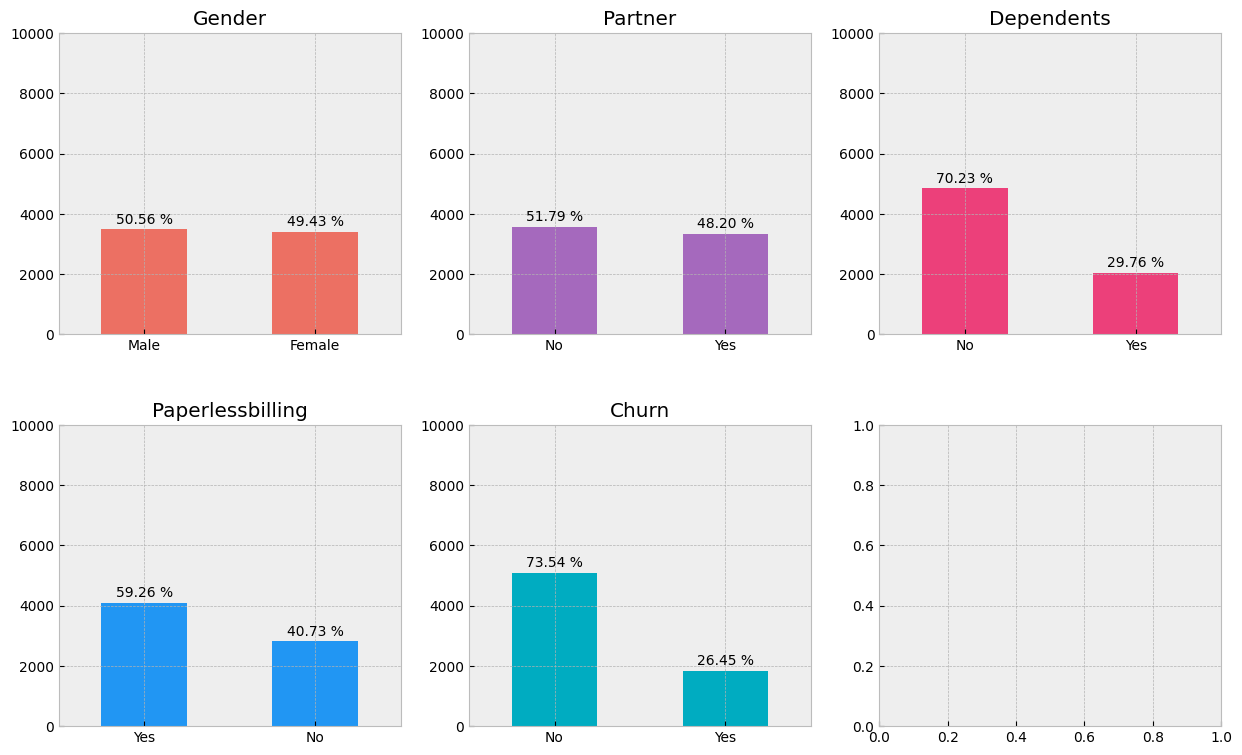

In [13]:
# take a subset of category columns to plot
categorical_plots(df, category_columns, 'categorical')

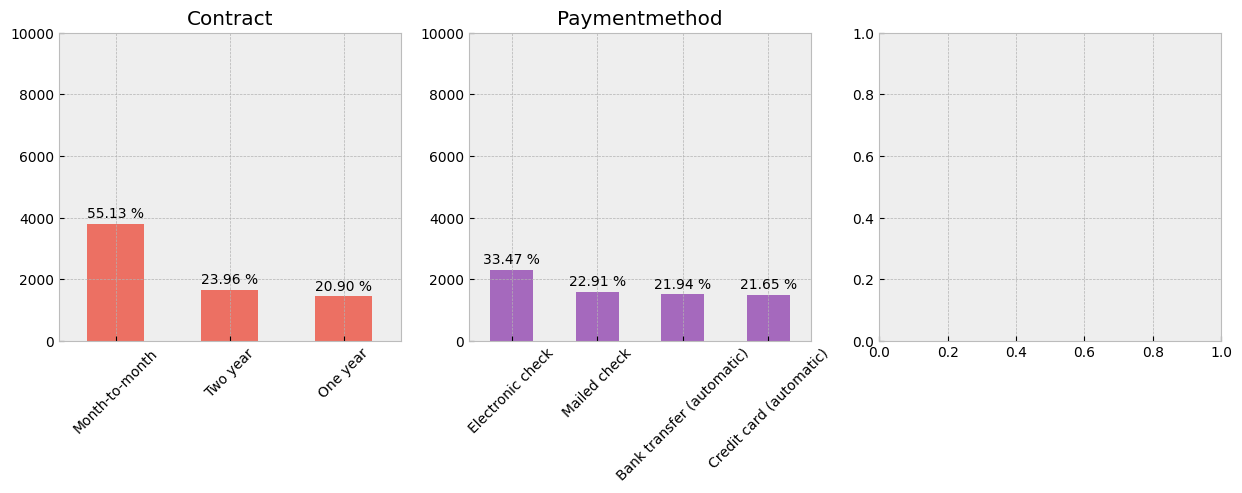

In [14]:
categorical_plots(df, ordinal_columns, 'ordinal')

In [15]:
def numeric_plot(df, numeric_cols, type):

    fig_num, axes_num = plt.subplots(1,4, figsize= (18,5))

    colors = ['#FB8C00','#EC407A', '#A569BD','#00ACC1']
    
    for index, axes in enumerate(axes_num.ravel()):
        if type == 'hist':
            plot = sns.histplot(df[numeric_cols[index]], 
                                kde=True, ax=axes, color = colors[index])
        elif type == 'box':
            plot =  sns.boxplot(df[numeric_cols[index]], 
                                ax=axes, color = colors[index])
        plot.set(xlabel = '', ylabel='Frequency', title = numeric_cols[index])
        
        
    fig_num.tight_layout()
    #plt.savefig(path + f'numeric-{type}-value.png')

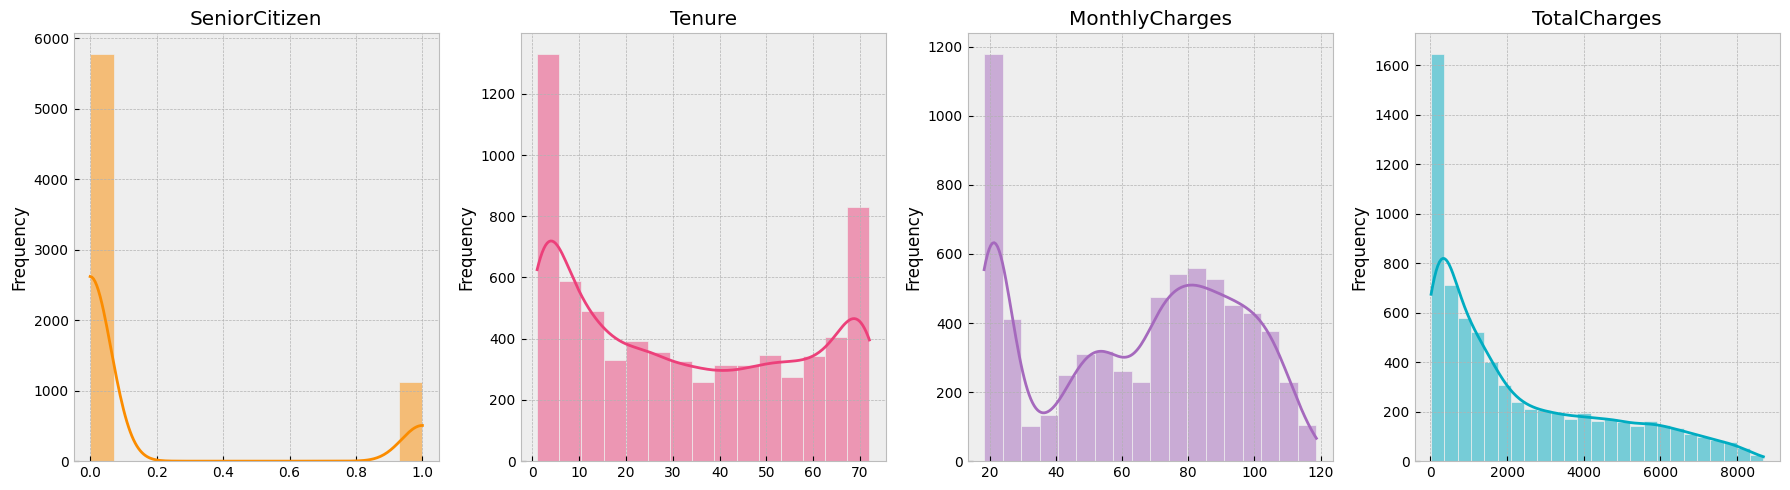

In [16]:
numeric_cols = df.select_dtypes('float64').columns.tolist()

numeric_plot(df, numeric_cols, 'hist')

### Bivariate Analysis

In [17]:
def bivariate_bar_plot(df, ordinal_columns, target_variabel, type):

    if type == 'bar':
    
        fig, axs = plt.subplots(1, 3, figsize=(12,5))
    
        colors = ["Set2", "flare"]
        
        for index, axes in enumerate(axs.flatten()):
            
            plot = sns.countplot(x = ordinal_columns[index], hue = target_variabel, data=df, 
                                 ax = axes, palette = colors[index])
        
            plot.set(xlabel='', ylabel = 'Frequency', title=ordinal_columns[index])
                        
            for index, p in enumerate(axes.patches):    
                height = p.get_height()
                x = p.get_x() + (p.get_width()/2)
                if x != 0.0:
                    axes.text(x, y = height + 30, s = '{:.0f}'.format(height), ha = 'center')
                    
    elif type == 'barstacked':
        
        fig, axs = plt.subplots(1,3, figsize = (18,5))
    
        colors = [['tomato','lightseagreen'], ['#A569BD','#00ACC1'], ['#00ACC1', '#FB8C00']]
        
        for index, axes in enumerate(axs.flatten()):
            df_stack = df.groupby([target_variabel, ordinal_columns[index]]).size().reset_index()
            df_stack = df_stack.pivot(columns= target_variabel, index= ordinal_columns[index], values=0)
            df_reverse = df_stack[df_stack.columns[::-1]]
            
            df_reverse.plot(kind='bar', stacked=True, ax = axes, 
                            title = ordinal_columns[index], color = colors[index],
                            ylabel = 'Frequency').set_xlabel("")
        
            axes.tick_params(axis='x', rotation=45)
            
            for c in axes.containers:
                label = [int(l.get_height()) for l in c]
                axes.bar_label(c, labels = label, label_type = 'edge') 

    #plt.savefig(path + f'bivariate-{type}-value.png')


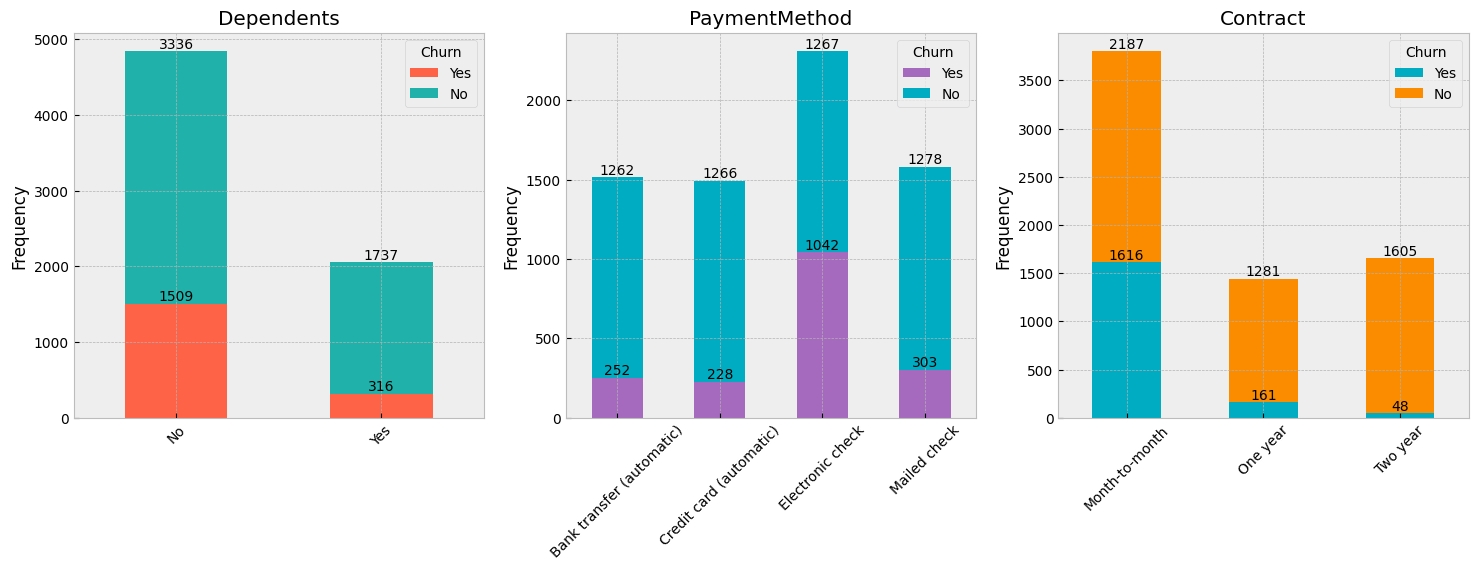

In [18]:
columns = ['Dependents', 'PaymentMethod', 'Contract']
bivariate_bar_plot(df, columns, 'Churn', 'barstacked')

### Multivariate Analysis

In [19]:
def multivariate_plots(df, numeric, category, target_variable):
    
    bin = np.linspace(df[numeric].min(), df[numeric].max(), 50)
    graph = sns.FacetGrid(df, col=category, hue = target_variable, palette="Set2", 
                          col_wrap=3, height = 7, aspect=1.1)
    graph.map(plt.hist, numeric, bins=bin, ec="k")
    
    for ax in graph.axes.ravel():
        ax.legend(title= target_variable)
        
    graph.set(ylabel = 'Frequency', xlabel= numeric)

    #plt.savefig(path + 'multivariate-value.png')
    
    plt.show()

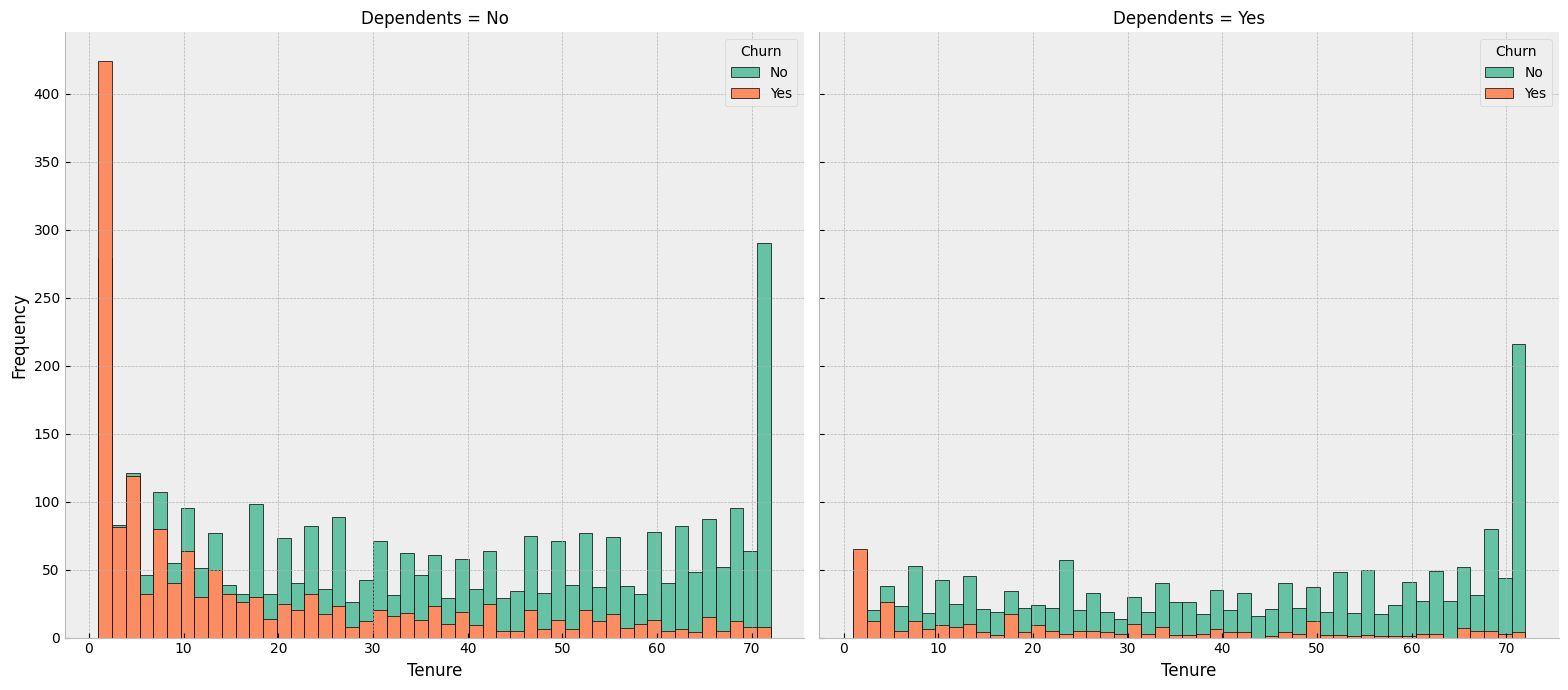

In [20]:
multivariate_plots(df, 'Tenure', 'Dependents', 'Churn')

## Data Transformation

- Unique value of categorical checking
- Label encoding
- One hot encoding

In [21]:
# Encode the categorical variable into numeric
def label_encoding(df, ordinal_columns):

    categoricals = df.drop(columns = ordinal_columns, axis=1).columns
    
    for col in categoricals:
        df[col] = df[col].replace({'Male' : 1.0, 'Female' : 0.0,
                                   'Yes' : 1.0, 'No' : 0.0})
        
    return df.drop(columns = 'customerID', axis=1)

# Encode ordinal columns, and drop first encoding-columns to avoid multicollinearity
def onehotencoding(df, columns):
    
    onehot = pd.DataFrame()
    for col in columns:
        encoding = pd.get_dummies(df[col], prefix=col, dtype='float')
        encoding = encoding.drop(encoding.columns[-1], axis=1)
        onehot = pd.concat([onehot, encoding], axis=1)
    
    return onehot

# Final cleaning to get feature and target data
def feature_cleaning(df, ordinal_columns):
    df_encode = label_encoding(df, ordinal_columns)

    # Drop the ordinal columns from dataframe first
    df_encode = df_encode.drop(columns=ordinal_columns)
    feature = df_encode.drop(columns='Churn')
    target = df_encode['Churn']
    target = target.astype('int')

    # Encode ordinal columns in the dataframe
    onehot = onehotencoding(df, ordinal_columns)
    feature = pd.concat([feature, onehot], axis=1)
    return feature, target

In [22]:
feature, target = feature_cleaning(df, ordinal_columns)

# Check the vif score
data = pd.concat([feature, target], axis=1)
data.head()

,Gender,SeniorCitizen,Partner,Dependents,Tenure,PaperlessBilling,MonthlyCharges,TotalCharges,Contract_Month-to-month,Contract_One year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,Churn
1,1.0,0.0,0.0,0.0,34.0,0.0,56.95,1889.50,0.0,1.0,0.0,0.0,0.0,0
2,1.0,0.0,0.0,0.0,2.0,1.0,53.85,108.15,1.0,0.0,0.0,0.0,0.0,1
3,1.0,0.0,0.0,0.0,45.0,0.0,42.30,1840.75,0.0,1.0,1.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,2.0,1.0,70.70,151.65,1.0,0.0,0.0,0.0,1.0,1
5,0.0,0.0,0.0,0.0,8.0,1.0,99.65,820.50,1.0,0.0,0.0,0.0,1.0,1


In [23]:
# Libraries to calculate multicollinearity or VIF (Variance Inflation Factor)
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant

# Calculate multicollinearity
def calculate_vif(feature):
    X = add_constant(feature)
    vif_df = pd.DataFrame([vif(X.values, i) for i in range(X.shape[1])], 
                          index = X.columns).reset_index()
    vif_df.columns = ['feature', 'vif_score']
    vif_df = vif_df.loc[vif_df.feature != 'const']
    return vif_df

In [24]:
calculate_vif(feature)

,feature,vif_score
1,Gender,1.000961
2,SeniorCitizen,1.132377
3,Partner,1.463645
4,Dependents,1.377666
5,Tenure,7.437790
6,PaperlessBilling,1.194019
7,MonthlyCharges,4.015121
8,TotalCharges,9.934806
9,Contract_Month-to-month,3.202233
10,Contract_One year,1.664813


In [25]:
# Drop MonthlyCharges and TotalCharges since their vif score are high/ high correlated
feature = feature.drop(columns='TotalCharges', axis=1)

In [26]:
calculate_vif(feature)

,feature,vif_score
1,Gender,1.000865
2,SeniorCitizen,1.131952
3,Partner,1.463335
4,Dependents,1.377257
5,Tenure,2.509355
6,PaperlessBilling,1.193489
7,MonthlyCharges,1.487157
8,Contract_Month-to-month,3.201572
9,Contract_One year,1.657801
10,PaymentMethod_Bank transfer (automatic),1.769404


<Axes: >

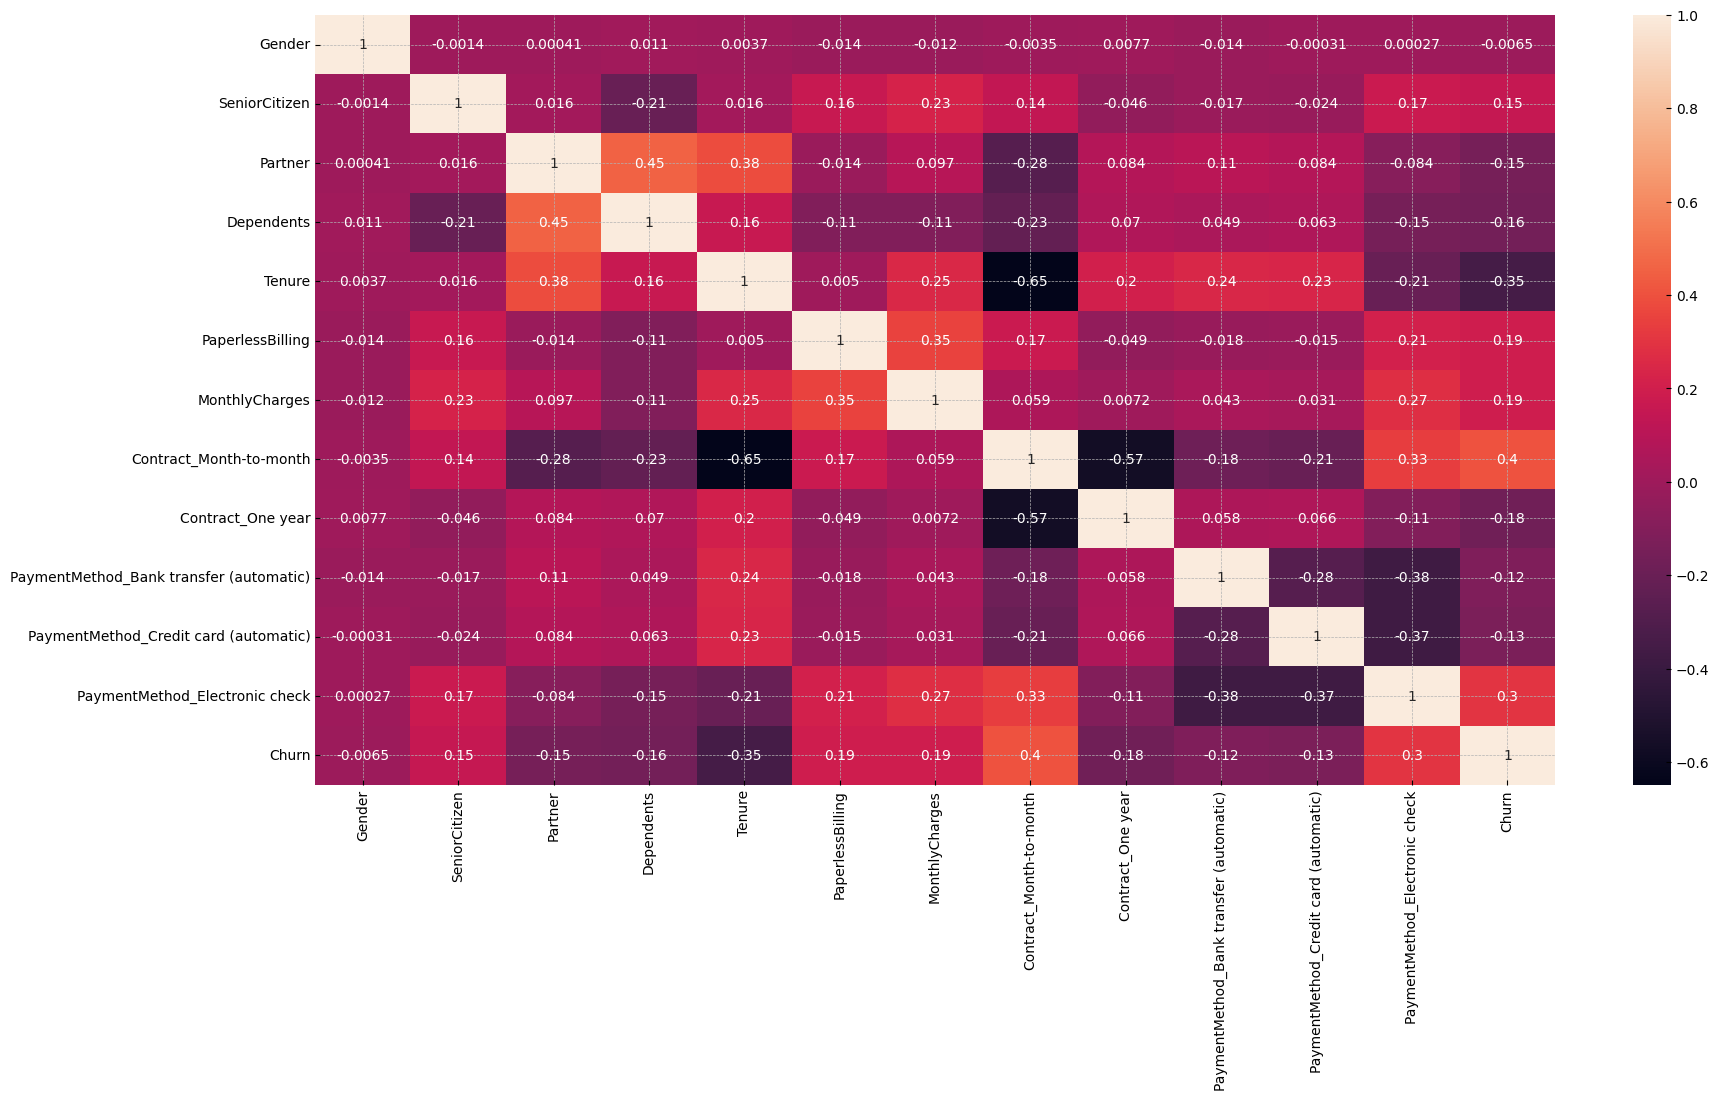

In [27]:
correlation = pd.concat([feature, target], axis=1)

plt.figure(figsize=(20,10))
sns.heatmap(correlation.corr(), annot=True)

## Data Preparation

In [28]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, recall_score
from sklearn.metrics import classification_report

X_pretrain, X_val, y_pretrain, y_val = train_test_split(feature, 
                                                        target, 
                                                        test_size=0.2,
                                                        random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X_pretrain, 
                                                    y_pretrain, 
                                                    test_size=0.2,
                                                    random_state=42)

# Original feature and target shape of our dataset
print('Shape of original feature data : {}'.format(feature.shape))
print('Shape of original target data : {}'.format(target.shape))
print()

# Shape of X_train and y_train data 
print('Shape of X_train data : {}'.format(X_train.shape))
print('Shape of y_train data : {}'.format(y_train.shape))
print()

# Shape of X_test and y_test data 
print('Shape of X_test data : {}'.format(X_test.shape))
print('Shape of y_test data : {}'.format(y_test.shape))
print()

# Shape of X_val and y_val data 
print('Shape of X_val data : {}'.format(X_val.shape))
print('Shape of y_val data : {}'.format(y_val.shape))
print()

Shape of original feature data : (6898, 12)
Shape of original target data : (6898,)

Shape of X_train data : (4414, 12)
Shape of y_train data : (4414,)

Shape of X_test data : (1104, 12)
Shape of y_test data : (1104,)

Shape of X_val data : (1380, 12)
Shape of y_val data : (1380,)



In [29]:
# Model fitting and calculation
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Decision tree classifier
tree = DecisionTreeClassifier()
tree.fit(X_train.to_numpy(), y_train.to_numpy())

# Random forest classifier
forest = RandomForestClassifier()
forest.fit(X_train.to_numpy(), y_train.to_numpy())

RandomForestClassifier()

In [30]:
def confusion_matrix_viz(model, X_train, X_test, X_val, y_train, y_test, y_val):

    name = type(model).__name__
    name = re.findall('[A-Z][^A-Z]*', name)
    model_name = ''.join(name[:-1])

    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    categories = ['No Churn', 'Churn']

    data_label = ['Training', 'Test', 'Validation']
    
    X = [X_train, X_test, X_val]
    y = [y_train, y_test, y_val]
    
    fig, axs = plt.subplots(1, 3, figsize=(20,5))

    for i, axes in enumerate(axs.flatten()):
        y_pred = model.predict(X[i])
        cm = confusion_matrix(y[i], y_pred)
    
        group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
        group_percentage = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
        
        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentage)]
        labels = np.asarray(labels).reshape(2,2)
    
        plot = sns.heatmap(cm, annot=labels, fmt='', 
                           ax = axes, cmap='Blues', cbar = True,
                           xticklabels = categories, yticklabels=categories)
        plot.set(title = model_name + ' --- ' + data_label[i], xlabel='Predicted Value', ylabel='True Value')

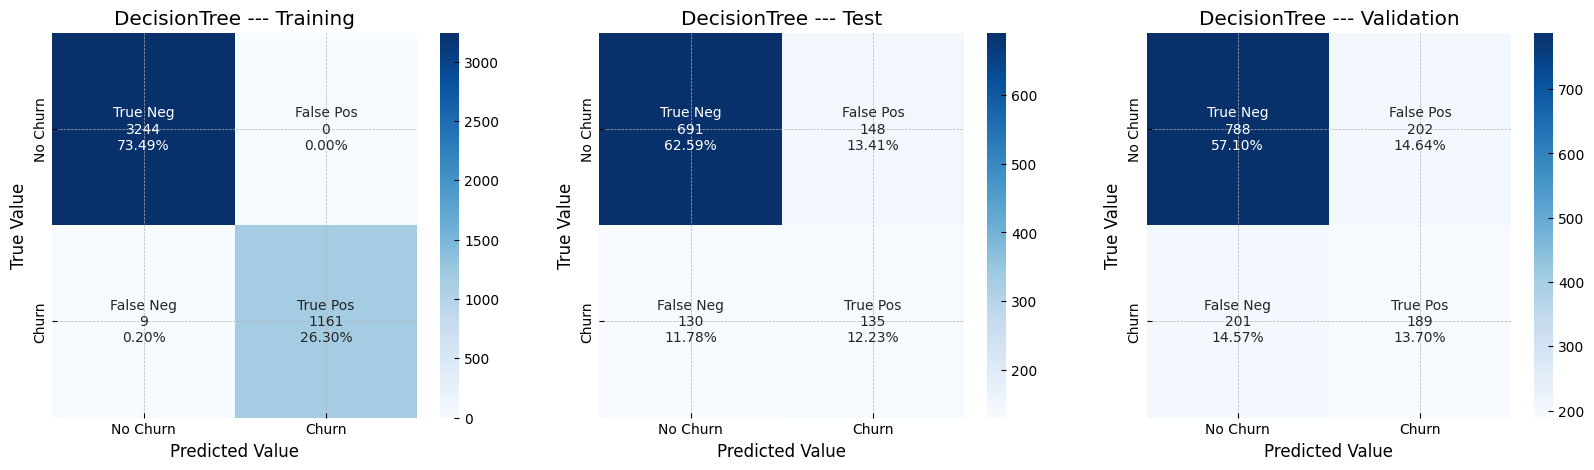

In [31]:
confusion_matrix_viz(tree, X_train, X_test, X_val, y_train, y_test, y_val)

In [32]:
y_pred = tree.predict(X_train)
labels = ['No Churn', 'Churn']

print(classification_report(y_train, y_pred, target_names= labels))

              precision    recall  f1-score   support

    No Churn       1.00      1.00      1.00      3244
       Churn       1.00      0.99      1.00      1170

    accuracy                           1.00      4414
   macro avg       1.00      1.00      1.00      4414
weighted avg       1.00      1.00      1.00      4414



In [33]:
y_pred = tree.predict(X_test)
labels = ['No Churn', 'Churn']

print(classification_report(y_test, y_pred, target_names= labels))

              precision    recall  f1-score   support

    No Churn       0.84      0.82      0.83       839
       Churn       0.48      0.51      0.49       265

    accuracy                           0.75      1104
   macro avg       0.66      0.67      0.66      1104
weighted avg       0.75      0.75      0.75      1104



In [34]:
y_pred = tree.predict(X_val)
labels = ['No Churn', 'Churn']

print(classification_report(y_val, y_pred, target_names= labels))

              precision    recall  f1-score   support

    No Churn       0.80      0.80      0.80       990
       Churn       0.48      0.48      0.48       390

    accuracy                           0.71      1380
   macro avg       0.64      0.64      0.64      1380
weighted avg       0.71      0.71      0.71      1380



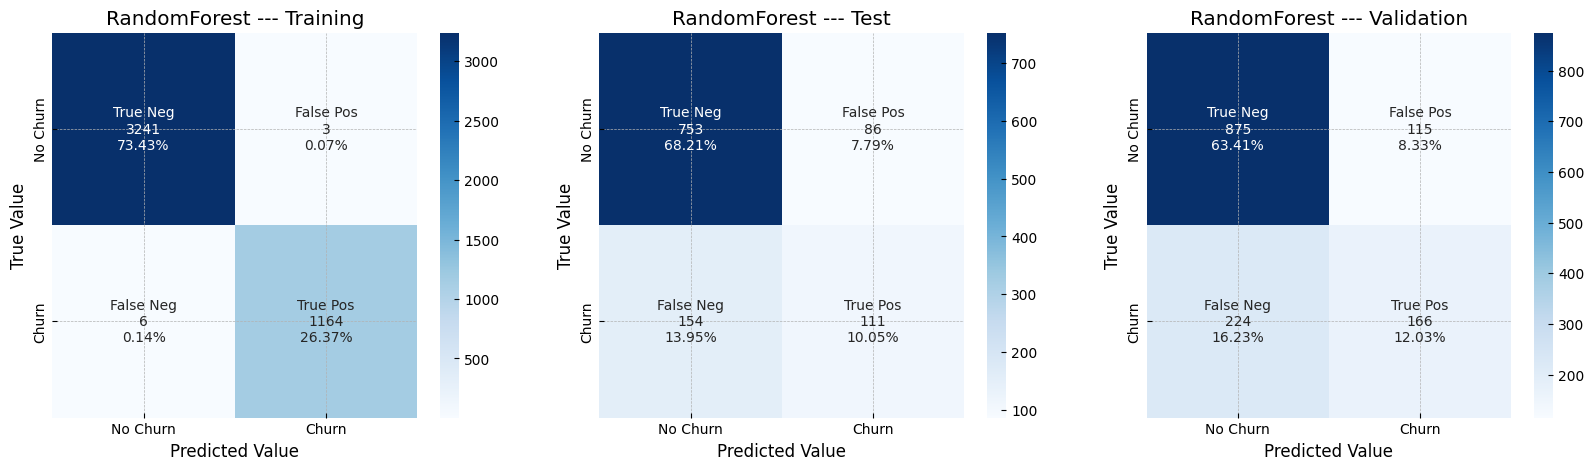

In [35]:
confusion_matrix_viz(forest, X_train, X_test, X_val, y_train, y_test, y_val)

In [36]:
y_pred = forest.predict(X_train)
labels = ['No Churn', 'Churn']

print(classification_report(y_train, y_pred, target_names= labels))

              precision    recall  f1-score   support

    No Churn       1.00      1.00      1.00      3244
       Churn       1.00      0.99      1.00      1170

    accuracy                           1.00      4414
   macro avg       1.00      1.00      1.00      4414
weighted avg       1.00      1.00      1.00      4414



In [37]:
y_pred = forest.predict(X_test)
labels = ['No Churn', 'Churn']

print(classification_report(y_test, y_pred, target_names= labels))

              precision    recall  f1-score   support

    No Churn       0.83      0.90      0.86       839
       Churn       0.56      0.42      0.48       265

    accuracy                           0.78      1104
   macro avg       0.70      0.66      0.67      1104
weighted avg       0.77      0.78      0.77      1104



In [38]:
y_pred = forest.predict(X_val)
labels = ['No Churn', 'Churn']

print(classification_report(y_val, y_pred, target_names= labels))

              precision    recall  f1-score   support

    No Churn       0.80      0.88      0.84       990
       Churn       0.59      0.43      0.49       390

    accuracy                           0.75      1380
   macro avg       0.69      0.65      0.67      1380
weighted avg       0.74      0.75      0.74      1380



In [39]:
def feature_importance_viz(model, feature):

    name = type(model).__name__
    name = re.findall('[A-Z][^A-Z]*', name)
    model_name = ''.join(name[:-1])
    
    feature_importance = model.feature_importances_
    importance = pd.Series(feature_importance, index = feature.columns)
    
    fig, ax = plt.subplots(figsize=(7,7))
    importance.plot.barh(ax=ax)
    ax.set_title("Feature importances contribution of " + model_name)
        
    plt.show()

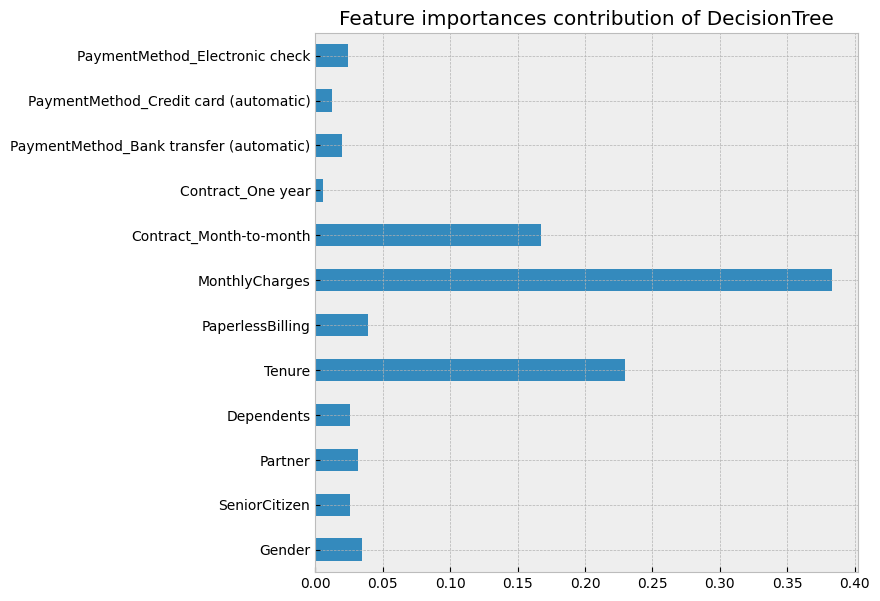

In [40]:
feature_importance_viz(tree, feature)

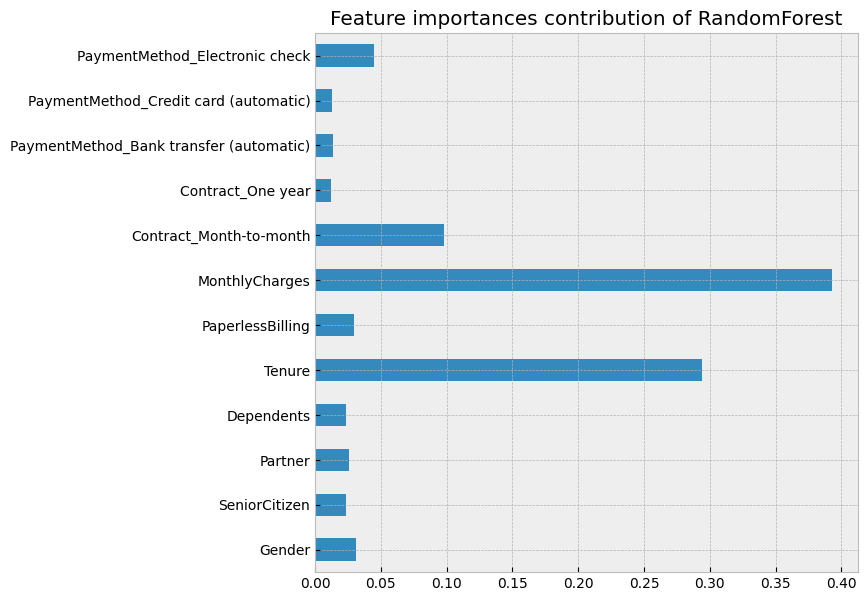

In [41]:
feature_importance_viz(forest, feature)

### Decision Tree Hyperparameter Tuning

In [42]:
from sklearn.model_selection import GridSearchCV

parameters_tree = {'criterion' : ['gini', 'entropy'],
                   'max_depth' : [2, 3, 5, 7, 9, 11],
                   'min_samples_split' : [2, 4, 6],
                   'max_leaf_nodes' : [3, 5, 7, 9, 11, 13, 15, 17, 19]}

tree_hyper = DecisionTreeClassifier(random_state = 42)

gridcv_tree = GridSearchCV(tree_hyper, parameters_tree, cv=5, 
                           scoring = 'recall', n_jobs=-1)

# conduct grid search over the parameter space
start_time = time.time()

gridcv_tree.fit(X_train,y_train)

duration = time.time() - start_time

In [43]:
# the compact results
cv_result = pd.DataFrame(gridcv_tree.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result[retain_cols].sort_values('rank_test_score', ascending=True)

,params,mean_test_score,rank_test_score
191,"{'criterion': 'entropy', 'max_depth': 3, 'max_...",0.629060,1
182,"{'criterion': 'entropy', 'max_depth': 2, 'max_...",0.629060,1
183,"{'criterion': 'entropy', 'max_depth': 2, 'max_...",0.629060,1
184,"{'criterion': 'entropy', 'max_depth': 2, 'max_...",0.629060,1
185,"{'criterion': 'entropy', 'max_depth': 2, 'max_...",0.629060,1
...,...,...,...
211,"{'criterion': 'entropy', 'max_depth': 3, 'max_...",0.396581,277
210,"{'criterion': 'entropy', 'max_depth': 3, 'max_...",0.396581,277
209,"{'criterion': 'entropy', 'max_depth': 3, 'max_...",0.396581,277
207,"{'criterion': 'entropy', 'max_depth': 3, 'max_...",0.396581,277


In [44]:
# show best parameter configuration found for classifier
print('Best parameters for Decision Tree : {}'.format(gridcv_tree.best_params_))
print('Computation time : %.2f' %duration)

Best parameters for Decision Tree : {'criterion': 'entropy', 'max_depth': 2, 'max_leaf_nodes': 3, 'min_samples_split': 2}
Computation time : 25.65


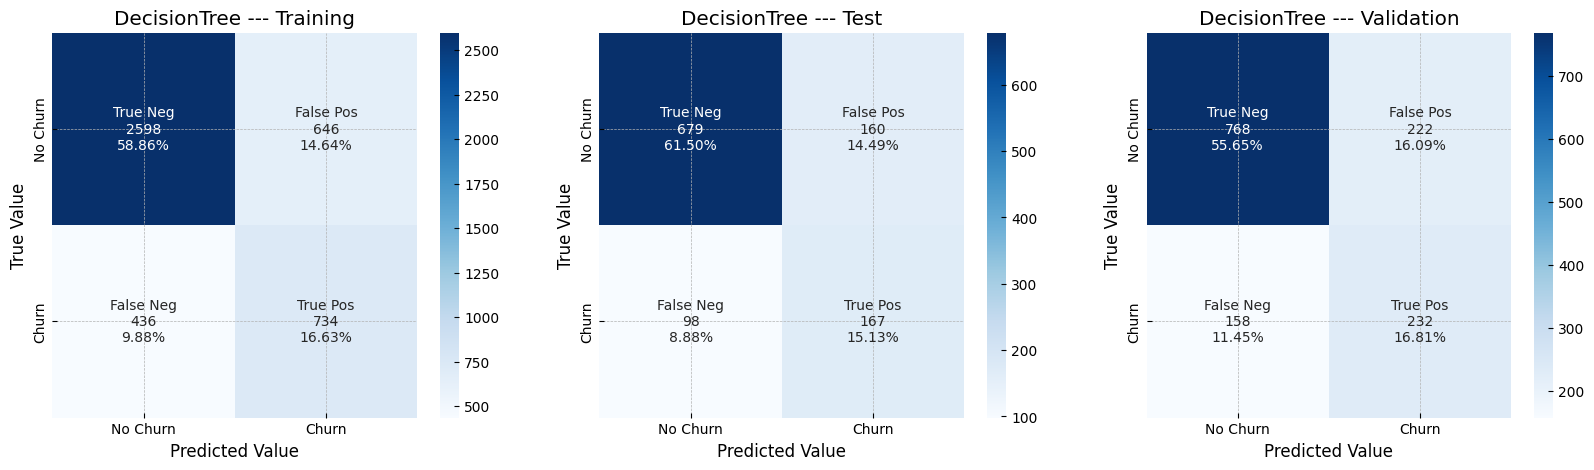

In [45]:
tree_best = gridcv_tree.best_estimator_
confusion_matrix_viz(tree_best, X_train, X_test, X_val, y_train, y_test, y_val)

In [46]:
y_pred = tree_best.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.80      0.83      3244
           1       0.53      0.63      0.58      1170

    accuracy                           0.75      4414
   macro avg       0.69      0.71      0.70      4414
weighted avg       0.77      0.75      0.76      4414



In [47]:
y_pred = tree_best.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.81      0.84       839
           1       0.51      0.63      0.56       265

    accuracy                           0.77      1104
   macro avg       0.69      0.72      0.70      1104
weighted avg       0.79      0.77      0.77      1104



In [48]:
y_pred = tree_best.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.78      0.80       990
           1       0.51      0.59      0.55       390

    accuracy                           0.72      1380
   macro avg       0.67      0.69      0.68      1380
weighted avg       0.74      0.72      0.73      1380



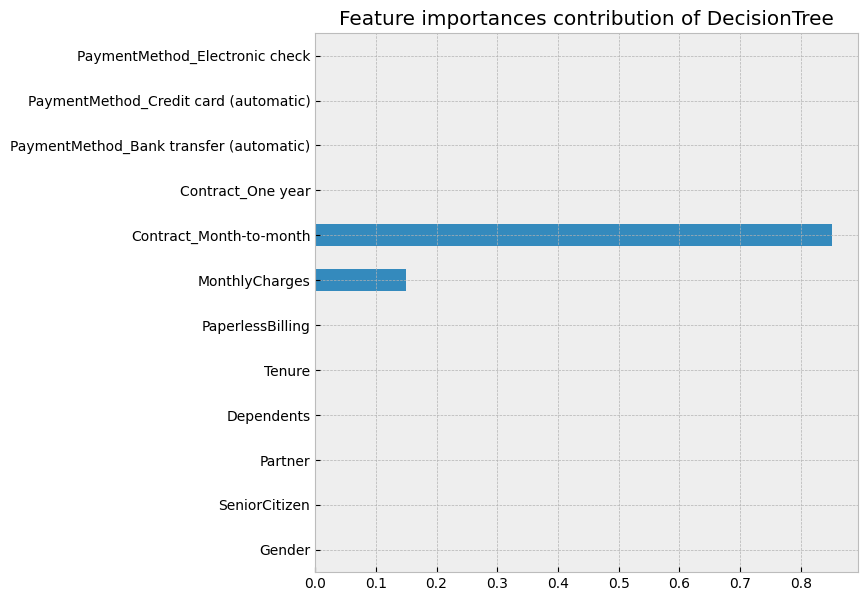

In [49]:
feature_importance_viz(tree_best, feature)

### Random Forest Hyperparameter Tuning

In [50]:
# Defined criterion
criterion = ['gini', 'entropy']

# Number of features to consider at every split
max_features = ['sqrt', 'log2']

# Maximum number of levels in tree
max_depth = [2, 3, 5, 7, 9, 11]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
parameters_forest = {'criterion' : criterion,
                     'max_features': max_features,
                     'max_depth': max_depth,
                     'min_samples_split': min_samples_split,
                     'min_samples_leaf': min_samples_leaf}
parameters_forest

{'criterion': ['gini', 'entropy'],
 'max_features': ['sqrt', 'log2'],
 'max_depth': [2, 3, 5, 7, 9, 11],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4]}

In [51]:
forest_hyper = RandomForestClassifier(random_state = 42)


gridcv_forest = GridSearchCV(forest_hyper, parameters_forest, cv=5, 
                             scoring = 'recall', n_jobs=-1)

# conduct grid search over the parameter space
start_time = time.time()

gridcv_forest.fit(X_train,y_train)

duration = time.time() - start_time

In [52]:
# the compact results
cv_result = pd.DataFrame(gridcv_forest.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result[retain_cols].sort_values('rank_test_score', ascending=True)

,params,mean_test_score,rank_test_score
75,"{'criterion': 'gini', 'max_depth': 9, 'max_fea...",0.498291,1
102,"{'criterion': 'gini', 'max_depth': 11, 'max_fe...",0.498291,1
93,"{'criterion': 'gini', 'max_depth': 11, 'max_fe...",0.498291,1
84,"{'criterion': 'gini', 'max_depth': 9, 'max_fea...",0.498291,1
73,"{'criterion': 'gini', 'max_depth': 9, 'max_fea...",0.497436,5
...,...,...,...
114,"{'criterion': 'entropy', 'max_depth': 2, 'max_...",0.083761,199
115,"{'criterion': 'entropy', 'max_depth': 2, 'max_...",0.083761,199
117,"{'criterion': 'entropy', 'max_depth': 2, 'max_...",0.083761,199
109,"{'criterion': 'entropy', 'max_depth': 2, 'max_...",0.083761,199


In [53]:
# show best parameter configuration found for classifier
print('Best parameters for Decision Tree : {}'.format(gridcv_forest.best_params_))
print('Computation time : %.2f' %duration)

Best parameters for Decision Tree : {'criterion': 'gini', 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2}
Computation time : 259.15


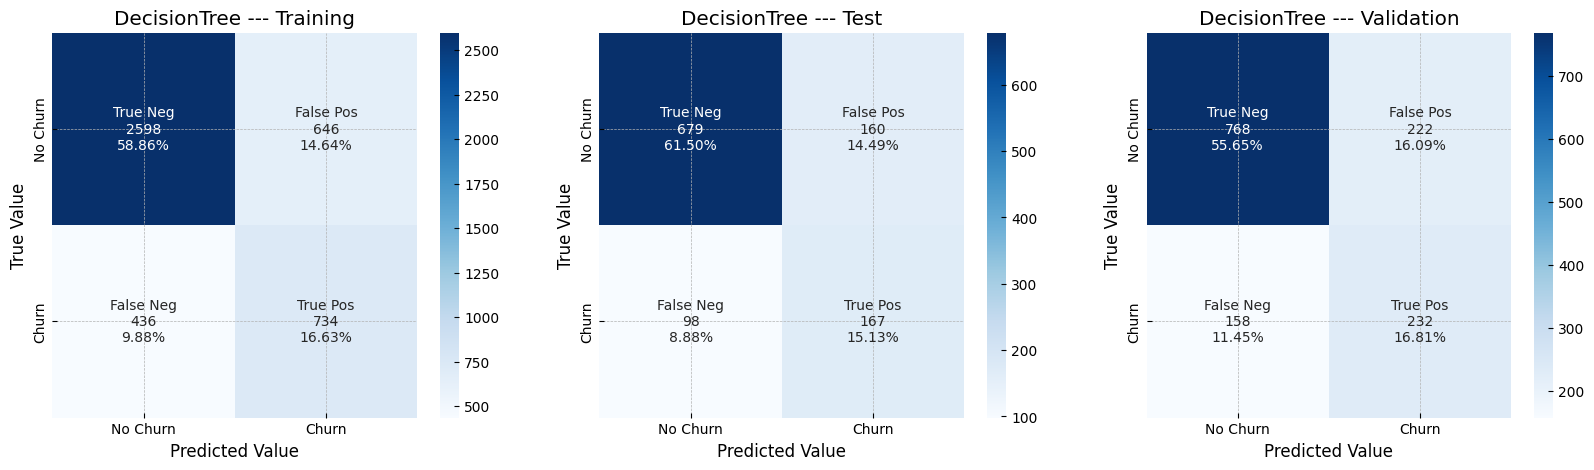

In [54]:
forest_best = gridcv_forest.best_estimator_
confusion_matrix_viz(tree_best, X_train, X_test, X_val, y_train, y_test, y_val)

In [55]:
y_pred = forest_best.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      3244
           1       0.78      0.59      0.67      1170

    accuracy                           0.85      4414
   macro avg       0.82      0.77      0.79      4414
weighted avg       0.84      0.85      0.84      4414



In [56]:
y_pred = forest_best.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.92      0.87       839
           1       0.62      0.43      0.51       265

    accuracy                           0.80      1104
   macro avg       0.73      0.67      0.69      1104
weighted avg       0.78      0.80      0.79      1104



In [57]:
y_pred = forest_best.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.90      0.85       990
           1       0.64      0.45      0.53       390

    accuracy                           0.77      1380
   macro avg       0.72      0.67      0.69      1380
weighted avg       0.76      0.77      0.76      1380



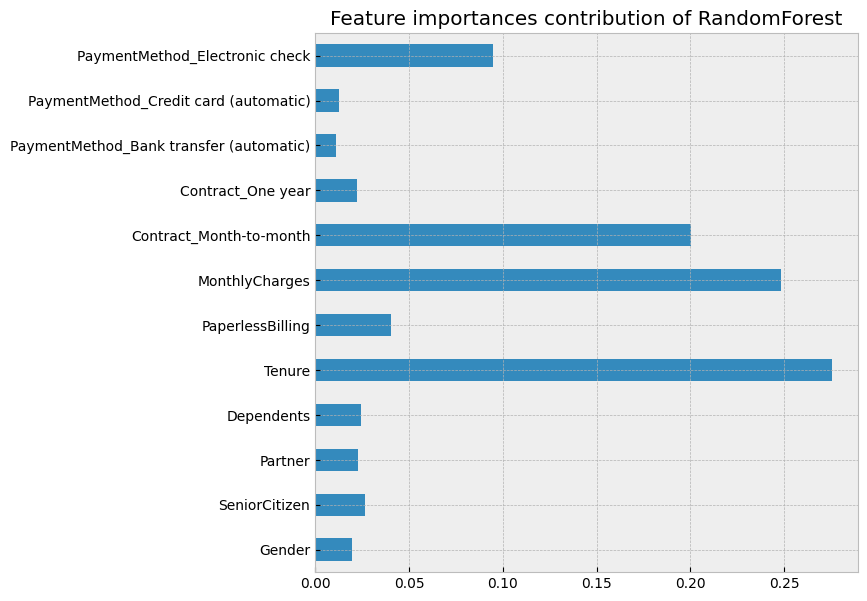

In [58]:
feature_importance_viz(forest_best, feature)

## Imbalanced data handling

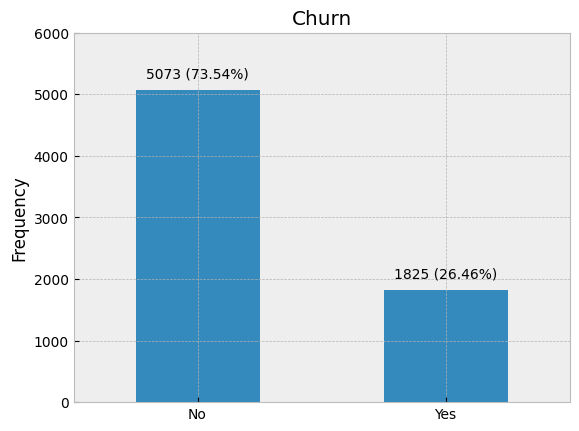

In [59]:
def imbalanced_viz(target):
    target_class = target.map({0 : 'No', 1 : 'Yes'})
    
    target_class.value_counts().plot(kind='bar', title='Churn')
    plt.tick_params(axis='x', rotation=0)
    plt.xlabel('')
    plt.ylabel('Frequency')
    
    counts = target_class.value_counts()
    percentage = counts / np.sum(counts) * 100
    
    labels = [str(counts[0]) + " (" + f'{percentage[0]:.2f}' + '%' + ")",
              str(counts[1]) + " (" + f'{percentage[1]:.2f}' + '%' + ")"]
    
    for i in range(len(labels)):
        plt.text(i, counts[i] + 200, labels[i], 
                 ha='center', color = 'black', fontsize=10)
    
    plt.ylim(0,6000)
    plt.show()

imbalanced_viz(target)

## SMOTE

In [60]:
from imblearn.over_sampling import SMOTE


X_pretrain, X_val, y_pretrain, y_val = train_test_split(feature, target, 
                                                        test_size=0.2,
                                                        random_state = 42)

# do oversampling using smote                                                        
smote = SMOTE(random_state=42, k_neighbors=5)
X_resample, y_resample = smote.fit_resample(X_pretrain, y_pretrain)

# do split again
X_train, X_test, y_train, y_test = train_test_split(X_resample, y_resample, 
                                                    test_size=0.2,
                                                    random_state = 42)


# Training data shape after SMOTE
print('Shape of X_train after SMOTE : {}'.format(X_train.shape))
print('Shape of y_train after SMOTE : {}'.format(y_train.shape))
print()

# Testing data shape after SMOTE
print('Shape of X_test after SMOTE : {}'.format(X_test.shape))
print('Shape of y_test after SMOTE : {}'.format(y_test.shape))
print()

# Valication data shape before SMOTE, this is set as a unlooked up data from machine learning model
print('Shape of X_val before SMOTE : {}'.format(X_val.shape))
print('Shape of y_val before SMOTE : {}'.format(y_val.shape))

Shape of X_train after SMOTE : (6532, 12)
Shape of y_train after SMOTE : (6532,)

Shape of X_test after SMOTE : (1634, 12)
Shape of y_test after SMOTE : (1634,)

Shape of X_val before SMOTE : (1380, 12)
Shape of y_val before SMOTE : (1380,)


In [61]:
# Decision tree classifier
tree_smote = DecisionTreeClassifier()
tree_smote.fit(X_train, y_train)

# Random forest classifier
forest_smote = RandomForestClassifier()
forest_smote.fit(X_train, y_train)

RandomForestClassifier()

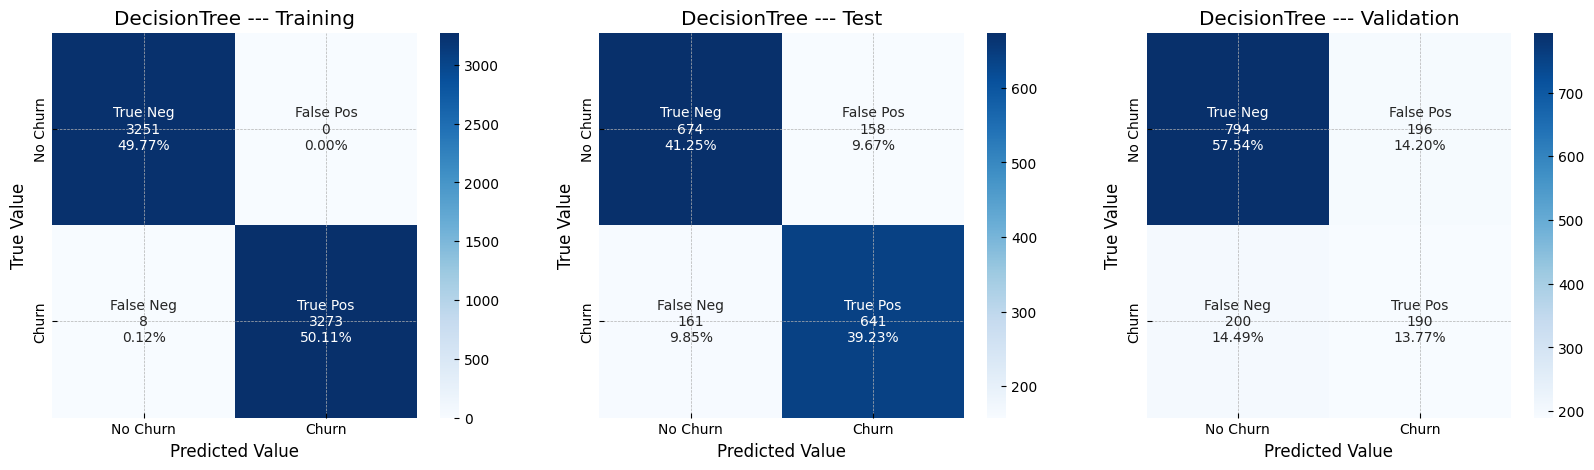

In [62]:
confusion_matrix_viz(tree_smote, X_train, X_test, X_val, y_train, y_test, y_val)

In [63]:
y_pred = tree_smote.predict(X_train)
labels = ['No Churn', 'Churn']

print(classification_report(y_train, y_pred, target_names= labels))

              precision    recall  f1-score   support

    No Churn       1.00      1.00      1.00      3251
       Churn       1.00      1.00      1.00      3281

    accuracy                           1.00      6532
   macro avg       1.00      1.00      1.00      6532
weighted avg       1.00      1.00      1.00      6532



In [64]:
y_pred = tree_smote.predict(X_test)
labels = ['No Churn', 'Churn']

print(classification_report(y_test, y_pred, target_names= labels))

              precision    recall  f1-score   support

    No Churn       0.81      0.81      0.81       832
       Churn       0.80      0.80      0.80       802

    accuracy                           0.80      1634
   macro avg       0.80      0.80      0.80      1634
weighted avg       0.80      0.80      0.80      1634



In [65]:
y_pred = tree_smote.predict(X_val)
labels = ['No Churn', 'Churn']

print(classification_report(y_val, y_pred, target_names= labels))

              precision    recall  f1-score   support

    No Churn       0.80      0.80      0.80       990
       Churn       0.49      0.49      0.49       390

    accuracy                           0.71      1380
   macro avg       0.65      0.64      0.65      1380
weighted avg       0.71      0.71      0.71      1380



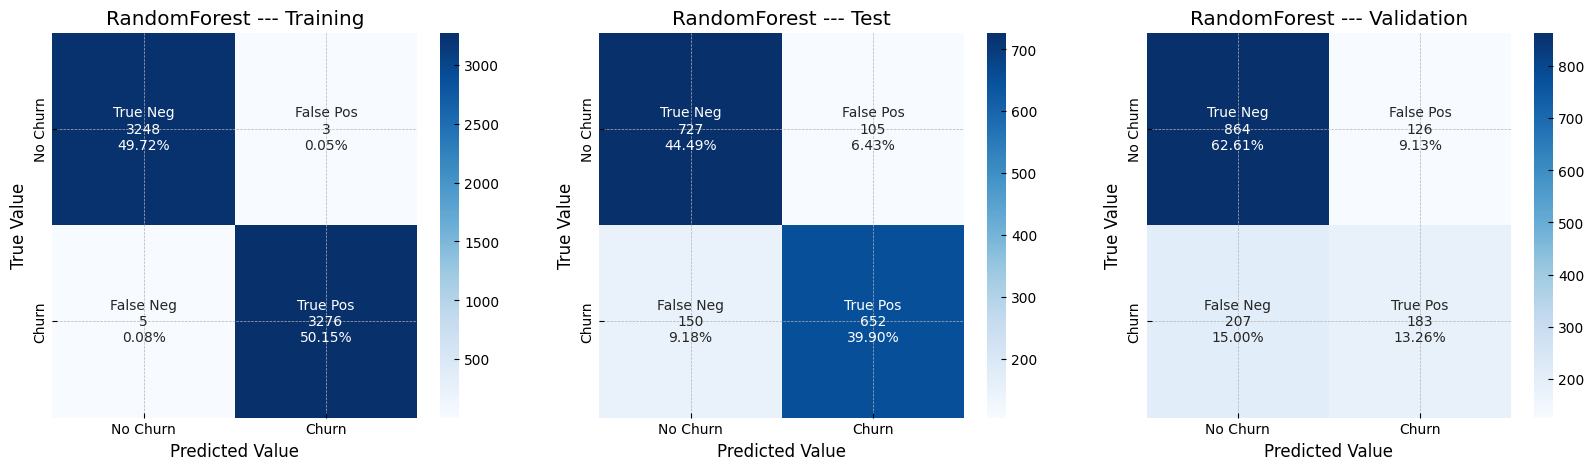

In [66]:
confusion_matrix_viz(forest_smote, X_train, X_test, X_val, y_train, y_test, y_val)

In [67]:
y_pred = forest_smote.predict(X_train)
labels = ['No Churn', 'Churn']

print(classification_report(y_train, y_pred, target_names= labels))

              precision    recall  f1-score   support

    No Churn       1.00      1.00      1.00      3251
       Churn       1.00      1.00      1.00      3281

    accuracy                           1.00      6532
   macro avg       1.00      1.00      1.00      6532
weighted avg       1.00      1.00      1.00      6532



In [68]:
y_pred = forest_smote.predict(X_test)
labels = ['No Churn', 'Churn']

print(classification_report(y_test, y_pred, target_names= labels))

              precision    recall  f1-score   support

    No Churn       0.83      0.87      0.85       832
       Churn       0.86      0.81      0.84       802

    accuracy                           0.84      1634
   macro avg       0.85      0.84      0.84      1634
weighted avg       0.84      0.84      0.84      1634



In [69]:
y_pred = forest_smote.predict(X_val)
labels = ['No Churn', 'Churn']

print(classification_report(y_val, y_pred, target_names= labels))

              precision    recall  f1-score   support

    No Churn       0.81      0.87      0.84       990
       Churn       0.59      0.47      0.52       390

    accuracy                           0.76      1380
   macro avg       0.70      0.67      0.68      1380
weighted avg       0.75      0.76      0.75      1380



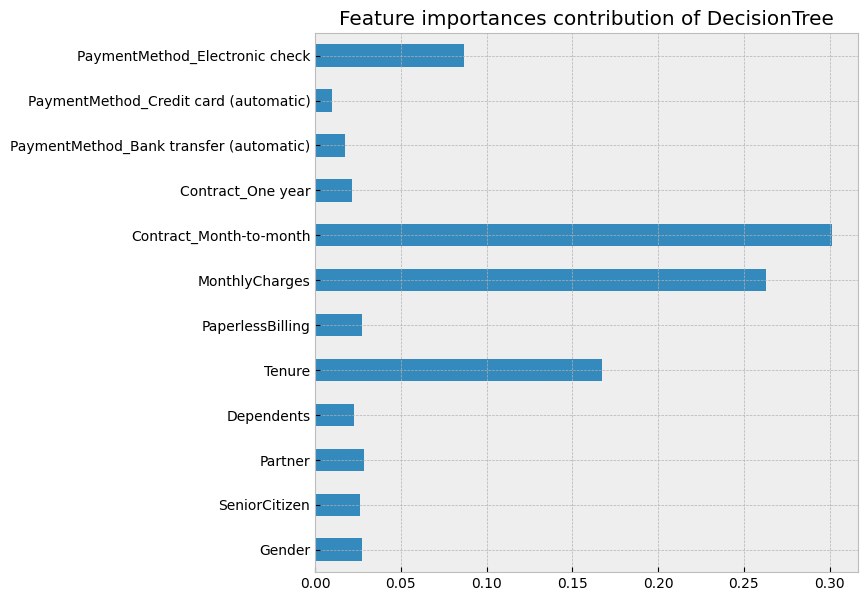

In [70]:
feature_importance_viz(tree_smote, feature)

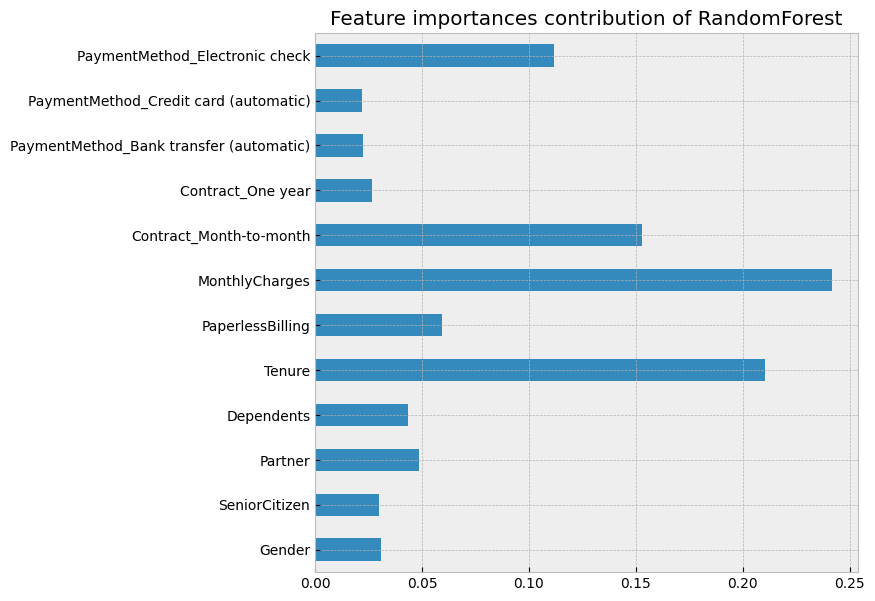

In [71]:
feature_importance_viz(forest_smote, feature)

## Hyperparameter Tuning

### Decision Tree with Balanced Data

In [72]:
from sklearn.model_selection import GridSearchCV

parameters_tree = {'criterion' : ['gini', 'entropy'],
                   'max_depth' : [2, 3, 5, 7, 9, 11],
                   'min_samples_split' : [2, 4, 6],
                   'max_leaf_nodes' : [3, 5, 7, 9, 11, 13, 15, 17, 19]}

tree_hyper = DecisionTreeClassifier(random_state = 42)

gridcv_tree = GridSearchCV(tree_hyper, parameters_tree, cv=5, 
                           scoring = 'accuracy', n_jobs=-1)

# conduct grid search over the parameter space
start_time = time.time()

gridcv_tree.fit(X_train,y_train)

duration = time.time() - start_time

In [73]:
# the compact results
cv_result = pd.DataFrame(gridcv_tree.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result[retain_cols].sort_values('rank_test_score', ascending=True)

,params,mean_test_score,rank_test_score
105,"{'criterion': 'gini', 'max_depth': 7, 'max_lea...",0.808177,1
106,"{'criterion': 'gini', 'max_depth': 7, 'max_lea...",0.808177,1
107,"{'criterion': 'gini', 'max_depth': 7, 'max_lea...",0.808177,1
161,"{'criterion': 'gini', 'max_depth': 11, 'max_le...",0.807871,4
160,"{'criterion': 'gini', 'max_depth': 11, 'max_le...",0.807871,4
...,...,...,...
180,"{'criterion': 'entropy', 'max_depth': 2, 'max_...",0.745103,226
181,"{'criterion': 'entropy', 'max_depth': 2, 'max_...",0.745103,226
182,"{'criterion': 'entropy', 'max_depth': 2, 'max_...",0.745103,226
175,"{'criterion': 'entropy', 'max_depth': 2, 'max_...",0.745103,226


In [74]:
# show best parameter configuration found for classifier
print('Best parameters for Decision Tree : {}'.format(gridcv_tree.best_params_))
print('Computation time : %.2f' %duration)

Best parameters for Decision Tree : {'criterion': 'gini', 'max_depth': 7, 'max_leaf_nodes': 19, 'min_samples_split': 2}
Computation time : 22.94


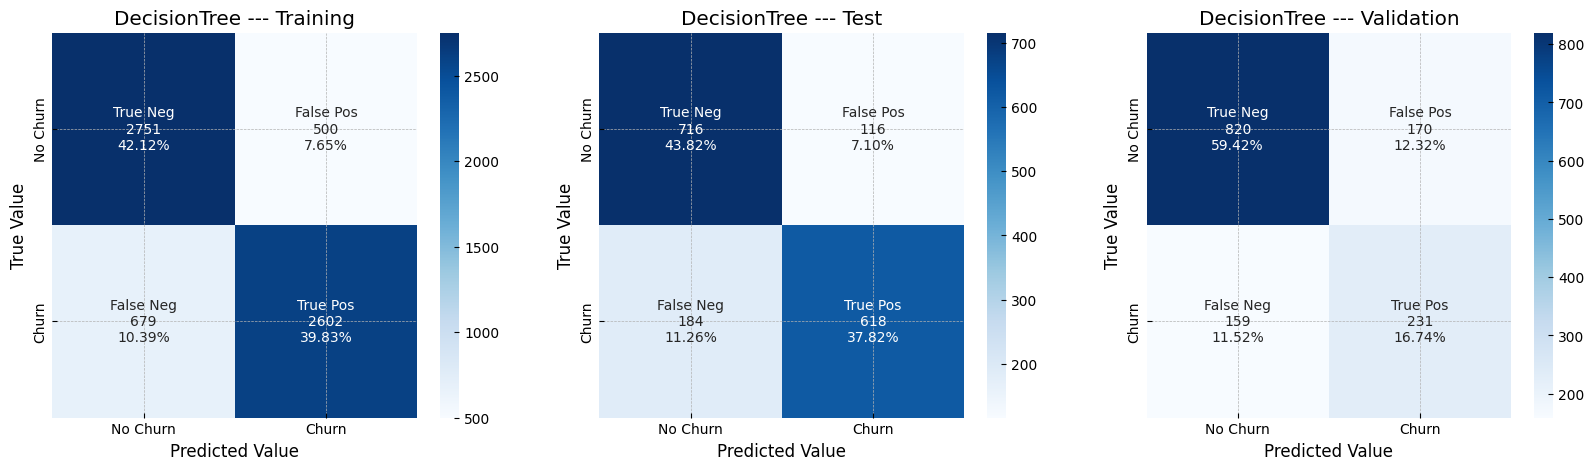

In [75]:
tree_best = gridcv_tree.best_estimator_
confusion_matrix_viz(tree_best, X_train, X_test, X_val, y_train, y_test, y_val)

In [76]:
y_pred = tree_best.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.85      0.82      3251
           1       0.84      0.79      0.82      3281

    accuracy                           0.82      6532
   macro avg       0.82      0.82      0.82      6532
weighted avg       0.82      0.82      0.82      6532



In [77]:
y_pred = tree_best.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83       832
           1       0.84      0.77      0.80       802

    accuracy                           0.82      1634
   macro avg       0.82      0.82      0.82      1634
weighted avg       0.82      0.82      0.82      1634



In [78]:
y_pred = tree_best.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83       990
           1       0.58      0.59      0.58       390

    accuracy                           0.76      1380
   macro avg       0.71      0.71      0.71      1380
weighted avg       0.76      0.76      0.76      1380



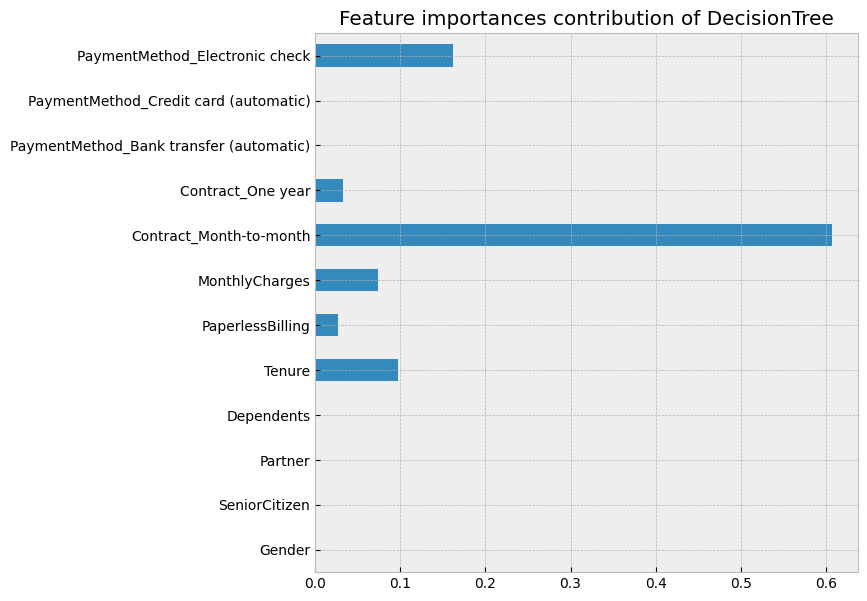

In [79]:
feature_importance_viz(tree_best, feature)

### Random Forest Hyperparameter Tuning with Balanced Data

In [80]:
# Defined criterion
criterion = ['gini', 'entropy']

# Number of features to consider at every split
max_features = ['sqrt', 'log2']

# Maximum number of levels in tree
max_depth = [2, 3, 5, 7, 9, 11]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
parameters_forest = {'criterion' : criterion,
                     'max_features': max_features,
                     'max_depth': max_depth,
                     'min_samples_split': min_samples_split,
                     'min_samples_leaf': min_samples_leaf}
parameters_forest

{'criterion': ['gini', 'entropy'],
 'max_features': ['sqrt', 'log2'],
 'max_depth': [2, 3, 5, 7, 9, 11],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4]}

In [81]:
forest_hyper = RandomForestClassifier(random_state = 42)


gridcv_forest = GridSearchCV(forest_hyper, parameters_forest, cv=5, 
                             scoring = 'accuracy', n_jobs=-1)

# conduct grid search over the parameter space
start_time = time.time()

gridcv_forest.fit(X_train,y_train)

duration = time.time() - start_time

In [82]:
# the compact results
cv_result = pd.DataFrame(gridcv_forest.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result[retain_cols].sort_values('rank_test_score', ascending=True)

,params,mean_test_score,rank_test_score
93,"{'criterion': 'gini', 'max_depth': 11, 'max_fe...",0.853184,1
102,"{'criterion': 'gini', 'max_depth': 11, 'max_fe...",0.853184,1
212,"{'criterion': 'entropy', 'max_depth': 11, 'max...",0.852725,3
203,"{'criterion': 'entropy', 'max_depth': 11, 'max...",0.852725,3
200,"{'criterion': 'entropy', 'max_depth': 11, 'max...",0.852419,5
...,...,...,...
14,"{'criterion': 'gini', 'max_depth': 2, 'max_fea...",0.782609,199
16,"{'criterion': 'gini', 'max_depth': 2, 'max_fea...",0.782609,199
17,"{'criterion': 'gini', 'max_depth': 2, 'max_fea...",0.782609,199
9,"{'criterion': 'gini', 'max_depth': 2, 'max_fea...",0.782609,199


In [83]:
# show best parameter configuration found for classifier
print('Best parameters for Decision Tree : {}'.format(gridcv_forest.best_params_))
print('Computation time : %.2f' %duration)

Best parameters for Decision Tree : {'criterion': 'gini', 'max_depth': 11, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2}
Computation time : 363.33


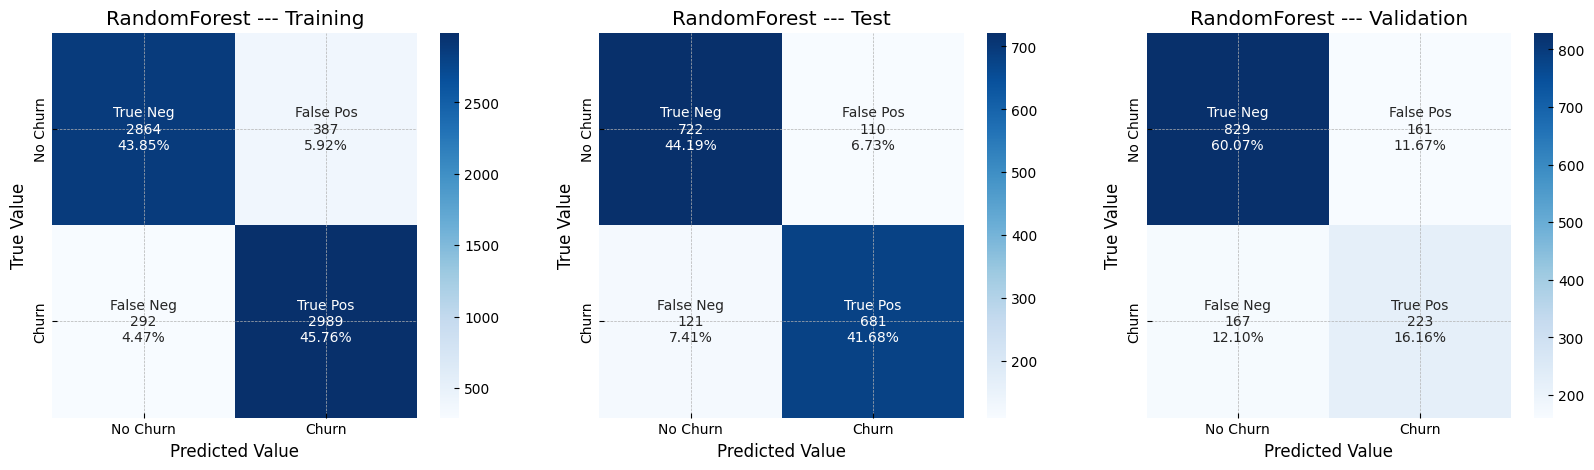

In [84]:
forest_best = gridcv_forest.best_estimator_
confusion_matrix_viz(forest_best, X_train, X_test, X_val, y_train, y_test, y_val)

In [85]:
y_pred = forest_best.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.88      0.89      3251
           1       0.89      0.91      0.90      3281

    accuracy                           0.90      6532
   macro avg       0.90      0.90      0.90      6532
weighted avg       0.90      0.90      0.90      6532



In [86]:
y_pred = forest_best.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.87      0.86       832
           1       0.86      0.85      0.85       802

    accuracy                           0.86      1634
   macro avg       0.86      0.86      0.86      1634
weighted avg       0.86      0.86      0.86      1634



In [87]:
y_pred = forest_best.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.84      0.83       990
           1       0.58      0.57      0.58       390

    accuracy                           0.76      1380
   macro avg       0.71      0.70      0.71      1380
weighted avg       0.76      0.76      0.76      1380



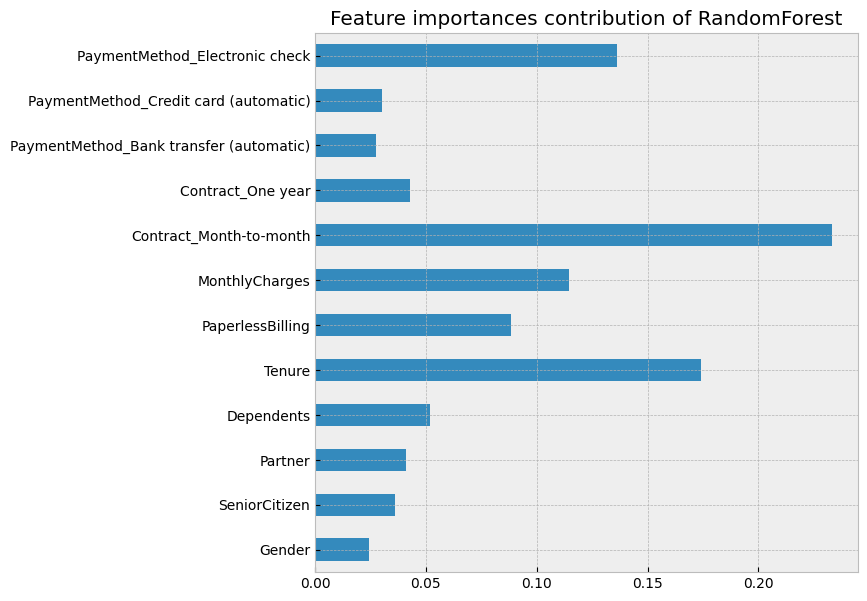

In [88]:
feature_importance_viz(forest_best, feature)